# Restaurants de Kolkata (Quaranteam)

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%%capture
cd kolkata-restaurant

In [3]:
# Requires some path juggling to be imported
from  main import simulate

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
%%capture
cd ..

# Introduction

Cette notebook contient les résultats obtenus du projet des Restaurants de Kolkata. Ce sont des observations et des mesures quantitatives de l'effectivité des agents selon les différentes strategies. Pour commencer on va donner une explication générale sur le fonctionnement du projet.

Le projet s'effectue dans le framework déjà utilisé dans ce cours, qui utilise des ontologies et des répresentations JSON des scénarios. On a adapté ainsi le code d'une des exemples de ce framework pour simuler notre scénario.

Avant du rapport, on doit un remarques sur le problème et l'implementation qu'on a considéré. On ne permet pas les agents de changer de restaurant objectif avant d'y arriver, ce qui n'a pas été specifié. Si on permet ce comportement, alors une stratégie du type occupation minimale et distance minimale semble quasi-optimale (car on peut toujours distribuer les agents de manière quasi-parfaite et ainsi achéver un score maximal).

## 1. Agents et restaurants: répresentation et fonctionnement

On a choisi de répresenter les **agents** par des classes ayant les attributs suivants:

- **id:** Indice de l'agent, qui l'identifique de manière univoque.
- **player:** Réference au joueur dans le framework.
- **pos:** Position actuelle de l'agent.
- **dims:** Dimensions du scénario.
- **dir_vecs:** Vecteurs directionnels, indicant les directions valides de déplacement (ceci permettrait de modifier le mouvement des agents de manière simple et efficace).
- **walls:** Réference à la liste des obstacles du scénario.
- **occupation:** Historique d'occupation des restaurants (c'est partie des connaissances de l'agent).
- **strategy:** Stratégie à suivre dans le scenario.
- **score:** Ponctuation de l'agent.
- **current:** Position relative dans le path vers la destination actuelle.
- **moving:** Indique si l'agent est en train de se déplacer.
- **waiting:** Indique si l'agent attend dans la queue d'un restaurant.
- **goal_idx:** Indique l'indice de la destination de l'agent.
- **verbose:** Indique si on veut des indications pour chaque action prise par les agents.


On dote aussi les agents des méthodes suivantes:

- **get_goal(self, restaurants, \*args, \*\*args):** Permet de calculer la nouvelle destination.
- **find_path(self):** Trouve le chemin vers la destination actuelle.
- **simulate(self):** Simule l'avance d'un pas de temps pour l'agent.

Pour les **restaurants**, on a une répresentation plus simple. Les attributs sont:

- **idgen:** Attribut statique qui génère l'id des restaurants.
- **id:** Identificateur du restaurant.
- **pos:** Position dans le scénario.
- **q:** File d'attente du restaurant.
- **verbose:** Indique si on veut des indications pour chaque action prise par les restaurants.

Et on a pour méthodes:

- **new_customer(self, customer):** ajoute un nouveau client à la file.
- **simulate(self):** simule l'avance d'un pas de temps pour le restaurant, en traitant le premier client de la file.

## 2. Stratégies

On a choisi de répresenter les stratégies comme des fonctions indépendantes ("standalone") des agents avec les mêmes arguments. On a commencé par définir les stratégies attendues, c'est-à-dire les strategies *aléatoire uniforme* et *tétue*.

**Aléatoire uniforme:** Retourne toujours un restaurant de manière complètement aléatoire.

**Tétue:** Retourne toujours le même restaurant.

Pour les autres stratégies, on a choisi d'implementer:

**Distance minimale:** Cherche un des restaurants les plus proches.

**Occupation minimale:** Cherche un des restaurants qui ont la plus baisse occupation à chaque instant ('forgetful')

**Occupation minimale moyenne:** Cherche un des restaurants qui one la plus baisse occupation en moyenne.

**Agent stochastique:** Le modèle de décision suit celle indiqué dans le livre *Econophysics of the Kolkata Restaurant Problem and Related Games* adaptée à notre cas particulier. Cette stratégie est défini par 2 formules qu'on va adapter à notre problème.

$$\large p_k(t)=\frac{1}{\mathcal{z}} \left[r_k^\alpha e^{-\frac{n_k(t-1)}{T}}\right] \qquad \mathcal{z}=\sum_{k=1}^{N}{\left[r_k^\alpha e^{-\frac{n_k(t-1)}{T}}\right]}$$

où $p_k(t)$ est la probabilité de choisir le k-ème restaurant au temps $t$, $r_k$ est le rank du k-ème restaurant, $\alpha\in\mathbb{R^+}$, $T\in(\mathbb{R^+}\setminus\{0\})$ est un facteur de scale de bruit et finalement $n_k(t-1)$ est l'occupation du k-ème restaurant à l'instant $t-1$. Dans notre cas, les ranks des restaurants ne sont pas un facteur à tenir en compte, et alors il est raisonnable de mettre $\alpha = 0$ pour faire que $r_k^\alpha = 1$. De plus, on doit choisir le facteur $T$. Selon les résultats du livre mentioné auparavant, on a 2 situations limite (p. 9)

1. Pour $\alpha=0$ et $T\rightarrow\infty$, $p_k(t)=\frac{1}{N}$ et on a un agent aléatoire uniforme.
2. Pour $\alpha=0$ et $T\rightarrow 0$, l'agent choisit encore de manière aléatoire mais maintenant évite les restaurants qui ont été visités le dernier jour (similairement à l'agent qui suit la stratégie d'occupation minimale). 

On va chosir alors une valeur intermédiaire de $T=1$. Ainsi, on arrive aux formules

$$\large p_k(t)=\frac{1}{\mathcal{z}}e^{-n_k(t-1)} \qquad \mathcal{z}=\sum_{k=1}^{N}{e^{-n_k(t-1)}}$$

# Résultats des stratégies

On laisse ici les résultats, en termes du score des joueurs, des strategies quand tous les agents (10) suivent la même strategie. On calcule les scores après 10 iterations de la simulation. Après, on calcule les statistiques suivantes:

- Valeur moyenne de chaque champ (mean)
- Écart type de chaque champ (std)
- Valeur minimum et maximum de chaque champ (min,max)
- Quartiles de chaque champ (25%,50%,75%)

In [5]:
def df_players_single_strategy(strategy,its=10):
    cols = ['Iteration', 'Cumulative Score', 'Average Score', 'Max Score', 'Min Score']
    data = {c:[] for c in cols}
    for i in range(its):
        stats = simulate(1,[strategy])
        stats = stats['players']
        data['Iteration'].append(i+1)
        data['Cumulative Score'].append(stats['cumulative'])
        data['Average Score'].append(stats['avg'])
        data['Max Score'].append(stats['max'])
        data['Min Score'].append(stats['min'])
    return pd.DataFrame.from_dict(data)

### 1. Tétue

Pour la stratégie tétue on attend en général des résultats de score très haut en moyenne, le seul problème posé étant la possible saturation des restaurants (si tous les agents choisissent le même par exemple).

In [9]:
df_tetue = df_players_single_strategy('random_obstinate')
df_tetue

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
0,43.5,435,1,88,25
1,50.7,507,2,75,24
2,35.2,352,3,73,23
3,26.5,265,4,36,17
4,34.9,349,5,47,18
5,34.7,347,6,72,19
6,41.0,410,7,72,23
7,50.1,501,8,88,17
8,36.2,362,9,96,16
9,35.7,357,10,89,12


In [10]:
df_tetue.describe()

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,38.850000,388.500000,5.50000,73.600000,19.400000
std,7.519198,75.191977,3.02765,19.097411,4.195235
min,26.500000,265.000000,1.00000,36.000000,12.000000
25%,34.975000,349.750000,3.25000,72.000000,17.000000
50%,35.950000,359.500000,5.50000,74.000000,18.500000
75%,42.875000,428.750000,7.75000,88.000000,23.000000
max,50.700000,507.000000,10.00000,96.000000,25.000000


On peut observer que l'écart type de la ponctuation est relativement haut (7.51 pour la ponctuation moyenne, presque un 19% de sa valeur moyenne). Ainsi, ça montre que la possible saturation des restaurants cause une variation importante de la ponctuation. De même, on peut l'observer dans les scores maximum et minimum, qui oscillent entre 36-96 et 12-25 respectivement.

### 2. Aléatoire uniforme

La stratégie aléatoire uniforme semble avoir un problème de base, et ceci est le temps qui est perdu pendant les déplacements des agents, qui doivent souvent changer de restaurant. D'autre côté, les attentes sont tout à fait minimisées.

In [11]:
df_aleatoire = df_players_single_strategy('uniformly_random')
df_aleatoire

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
0,4.4,44,1,8,3
1,4.3,43,2,5,3
2,5.1,51,3,7,4
3,4.4,44,4,6,3
4,4.5,45,5,6,3
5,4.2,42,6,6,3
6,4.5,45,7,7,3
7,5.6,56,8,9,3
8,4.7,47,9,8,3
9,4.8,48,10,8,3


In [12]:
df_aleatoire.describe()

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,4.650000,46.500000,5.50000,7.000000,3.100000
std,0.424918,4.249183,3.02765,1.247219,0.316228
min,4.200000,42.000000,1.00000,5.000000,3.000000
25%,4.400000,44.000000,3.25000,6.000000,3.000000
50%,4.500000,45.000000,5.50000,7.000000,3.000000
75%,4.775000,47.750000,7.75000,8.000000,3.000000
max,5.600000,56.000000,10.00000,9.000000,4.000000


Comme remarque, on peut voir que cette stratégie est plus stable que la stratégie tétue, avec un écart type de 0.42 (moins de 10% sur la valeur moyenne) et avec valeurs de score maximum et minimum oscillant entre 5-9 et 3-4 respectivement.

### 3. Distance minimale

La stratégie de distance minimale doit se comporter de manière similaire à celle de la stratégie tétue (car une fois un restaurant a été choisi, il sera le plus proche quand la décision suivante est prise).

In [14]:
df_min_dist = df_players_single_strategy('min_distance')
df_min_dist

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
0,55.7,557,1,95,29
1,37.5,375,2,99,14
2,37.6,376,3,94,17
3,55.8,558,4,97,22
4,38.5,385,5,92,21
5,46.5,465,6,98,28
6,45.6,456,7,92,22
7,38.5,385,8,94,17
8,37.9,379,9,98,28
9,47.4,474,10,100,17


In [15]:
df_min_dist.describe()

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,44.100000,441.000000,5.50000,95.900000,21.500000
std,7.282551,72.825514,3.02765,2.884826,5.359312
min,37.500000,375.000000,1.00000,92.000000,14.000000
25%,38.050000,380.500000,3.25000,94.000000,17.000000
50%,42.050000,420.500000,5.50000,96.000000,21.500000
75%,47.175000,471.750000,7.75000,98.000000,26.500000
max,55.800000,558.000000,10.00000,100.000000,29.000000


Les résultats sont similaires à celle de la stratégie tétue mais il y a une difference remarquable: le score maximum oscille seulement entre 92-100. Ceci correspond à la haute probabilité d'avoir un agent qui a un restaurant seulement pour lui. Notons qu'il y a des configurations où le résultat peut être indistinguible.

### 4. Ocupation minimale

Pour ce stratégie, on attend des résultats similaires à la stratégie aléatoire uniforme. La raison est que, quand la pool de restaurants est suffisamment grand, le choix est pratiquement fait de la même manière. La seule différence est que le retour au même restaurant est presque toujours penalisé (car il a été sûrement occupé par l'agent au moment précedent) ce qui entraine probablement des résultats plus bas.

In [16]:
df_min_occupation = df_players_single_strategy('min_occupation_forgetful')
df_min_occupation

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
0,4.9,49,1,8,3
1,4.4,44,2,6,3
2,4.4,44,3,6,3
3,4.0,40,4,6,3
4,4.2,42,5,6,3
5,4.2,42,6,10,3
6,4.5,45,7,6,3
7,5.2,52,8,8,4
8,4.1,41,9,6,3
9,5.9,59,10,10,3


In [17]:
df_min_occupation.describe()

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,4.580000,45.800000,5.50000,7.200000,3.100000
std,0.592171,5.921711,3.02765,1.686548,0.316228
min,4.000000,40.000000,1.00000,6.000000,3.000000
25%,4.200000,42.000000,3.25000,6.000000,3.000000
50%,4.400000,44.000000,5.50000,6.000000,3.000000
75%,4.800000,48.000000,7.75000,8.000000,3.000000
max,5.900000,59.000000,10.00000,10.000000,4.000000


### 5. Occupation minimale moyenne

On attend encore des résultats similaires à la stratégie aleatoire uniforme. La raison est que cette stratégie correspond à une stratégie aleatoire uniforme en priorisant les restaurants qui n'ont pas été visités encore (et ainsi en distribuant toujours les agents de manière uniforme dans les restaurants à la fin de la simulation). Le problème est ainsi le temps perdu dans des déplacements.

In [18]:
df_min_occupation_avg = df_players_single_strategy('min_occupation_avg')
df_min_occupation_avg

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
0,5.2,52,1,8,4
1,4.1,41,2,5,3
2,5.4,54,3,8,4
3,4.0,40,4,6,3
4,4.6,46,5,6,3
5,4.7,47,6,6,3
6,4.4,44,7,7,3
7,4.8,48,8,9,3
8,4.3,43,9,8,3
9,5.1,51,10,6,4


In [19]:
df_min_occupation_avg.describe()

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,4.660000,46.600000,5.50000,6.900000,3.300000
std,0.471876,4.718757,3.02765,1.286684,0.483046
min,4.000000,40.000000,1.00000,5.000000,3.000000
25%,4.325000,43.250000,3.25000,6.000000,3.000000
50%,4.650000,46.500000,5.50000,6.500000,3.000000
75%,5.025000,50.250000,7.75000,8.000000,3.750000
max,5.400000,54.000000,10.00000,9.000000,4.000000


On a tout a fait des résultats similaires à la stratégie aleatoire uniforme, avec la peculiarité d'avoir des quartiles séparés presque regulièrement.

### 6. Stochastic

In [6]:
df_stochastic = df_players_single_strategy('stochastic')
df_stochastic

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
0,4.3,43,1,8,3
1,4.3,43,2,6,4
2,4.4,44,3,5,4
3,4.4,44,4,6,3
4,4.1,41,5,5,3
5,4.2,42,6,7,3
6,3.9,39,7,5,3
7,4.4,44,8,5,3
8,5.1,51,9,9,3
9,4.1,41,10,5,4


In [8]:
df_stochastic.describe()

,Average Score,Cumulative Score,Iteration,Max Score,Min Score
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,4.320000,43.200000,5.50000,6.100000,3.300000
std,0.319026,3.190263,3.02765,1.449138,0.483046
min,3.900000,39.000000,1.00000,5.000000,3.000000
25%,4.125000,41.250000,3.25000,5.000000,3.000000
50%,4.300000,43.000000,5.50000,5.500000,3.000000
75%,4.400000,44.000000,7.75000,6.750000,3.750000
max,5.100000,51.000000,10.00000,9.000000,4.000000


Il y a quelques choses à remarquer. Pour commencer, on a des résultats similaires à la strategie aleatoire uniforme (en terme de score accumulé et moyen). Mais cette fois l'écart type est plus bas, d'un 7% environ. On a aussi des scores maximum et minimum oscillant entre 5-9 et 3-4 respectivement.

### Conclusions

On a pu voir les similitudes entre les méthodes tétue et distance minimale, ainsi que ceux entre le reste des stratégies. On laisse le graphique suivant pour illustrer ce qu'on a obtenu en terme du score attendu (approximé). On marque en bleu et en jaune les stratégies qui devraient avoir des résultats similaires.

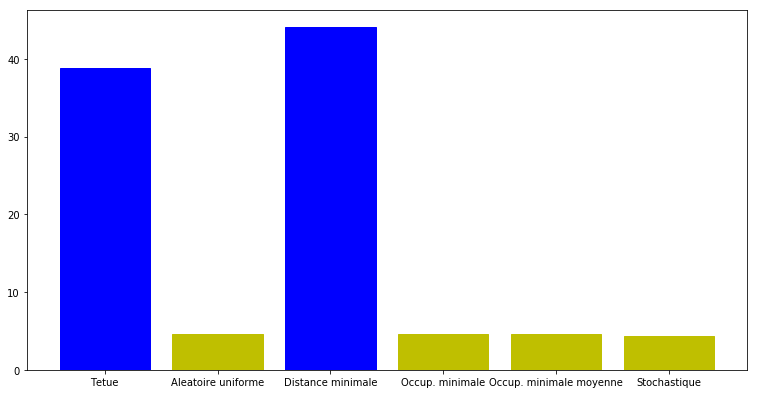

In [31]:
strat = ['Tetue','Aleatoire uniforme','Distance minimale','Occup. minimale', 'Occup. minimale moyenne','Stochastique']
score_attendu = [38.85, 4.65, 44.1, 4.55, 4.66, 4.32]
colors = ['b','y','b','y','y','y']
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(strat,score_attendu)
for x,c in zip(ax.get_children(), colors):
    x.set_color(c)
plt.show()

En séparant les stratégies similaires on obtient

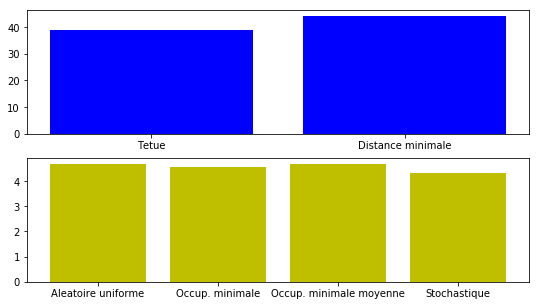

In [30]:
strat1 = ['Tetue','Distance minimale']
strat2 = ['Aleatoire uniforme','Occup. minimale', 'Occup. minimale moyenne','Stochastique']
score1 = [38.85, 44.1]
score2 = [4.65, 4.55, 4.66, 4.32]
fig,ax = plt.subplots(2,figsize=(9,5))
ax[0].bar(strat1,score1,color='b')
ax[1].bar(strat2,score2,color='y')
plt.show()

# Interactions entre les stratégies

Ici, on peut voir les stratégies en action quand on a 2 groupes d'agents (chacun d'entre eux qui suit une stratégie différente). On va récuperer les données des agents après chaque simulation, comme on a fait pour une seule stratégie mais aussi les données des agents appartenant à chaque groupe suivant une certaine stratégie.

In [5]:
def df_interaction(n, strategies, its=10):
    assert len(strategies) == n
    cols = ['Iteration', 'Cumulative Score', 'Average Score', 'Max Score', 'Min Score']
    data = [{c:[] for c in cols} for i in range(n)]
    data.append({c:[] for c in cols})
    for i in range(its):
        stats = simulate(n, strategies)
        # Build dataframes
        for j,s in zip(range(n),strategies):
            data[j]['Iteration'].append(i+1)
            data[j]['Cumulative Score'].append(stats[s]['cumulative'])
            data[j]['Average Score'].append(stats[s]['avg'])
            data[j]['Max Score'].append(stats[s]['max'])
            data[j]['Min Score'].append(stats[s]['min'])
        data[n]['Iteration'].append(i+1)
        data[n]['Cumulative Score'].append(stats['players']['cumulative'])
        data[n]['Average Score'].append(stats['players']['avg'])
        data[n]['Max Score'].append(stats['players']['max'])
        data[n]['Min Score'].append(stats['players']['min'])
    dfs = [pd.DataFrame.from_dict(d) for d in data]
    for i in range(n):
        dfs[i].name = strategies[i]
    dfs[n].name = 'Agents'
    return dfs

def display_data(df):
    print(df.name)
    print(df)
    print(df.describe())

## Aléatoire uniforme et Tétue

In [12]:
dfs = df_interaction(2, ['uniformly_random','random_obstinate'])

In [19]:
display_data(dfs[0])

uniformly_random
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0            3.6                18          1          4          3
1            3.6                18          2          4          3
2            4.8                24          3          6          4
3            4.6                23          4          7          3
4            3.8                19          5          5          3
5            5.0                25          6          7          4
6            4.2                21          7          6          3
7            4.2                21          8          6          3
8            4.0                20          9          5          3
9            3.8                19         10          5          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean        4.160000         20.800000    5.50000   5.500000   3.200000
std         0.49710

In [20]:
display_data(dfs[1])

random_obstinate
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           66.2               331          1         87         35
1           58.8               294          2         84         32
2           63.2               316          3         85         33
3           64.4               322          4         87         38
4           48.2               241          5         90         25
5           59.8               299          6         74         36
6           63.0               315          7         82         41
7           47.4               237          8         88         24
8           35.0               175          9         84         20
9           62.8               314         10         81         39
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean       56.880000        284.400000    5.50000  84.200000  32.300000
std        10.06653

In [21]:
display_data(dfs[2])

Agents
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           34.9               349          1         87          3
1           31.2               312          2         84          3
2           34.0               340          3         85          4
3           34.5               345          4         87          3
4           26.0               260          5         90          3
5           32.4               324          6         74          4
6           33.6               336          7         82          3
7           25.8               258          8         88          3
8           19.5               195          9         84          3
9           33.3               333         10         81          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean       30.520000        305.200000    5.50000  84.200000   3.200000
std         5.082607         

En ensmeble, il semble que le groupe qui suit la stratégie tétue profite d'avoir des agents aleatoires uniformes. Le score total des agents est cependant plus bas que l'attendu pour la stratégie tétu, mais plus haut que la moyenne entre ce qu'on attendait des deux stratégies. 

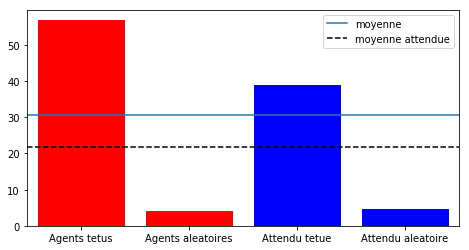

In [12]:
strat = ['Agents tetus','Agents aleatoires','Attendu tetue','Attendu aleatoire']
score_attendu = [56.88, 4.16,38.85, 4.65]
moyenne = (score_attendu[0]+score_attendu[1])/2
attendu_moyenne = (score_attendu[2] + score_attendu[3])/2
colors = ['r','r','b','b']
fig = plt.figure(figsize=(6,3))
ax = fig.add_axes([0,0,1,1])
ax.set_xlim(-0.5,3.5)
ax.plot([-0.5,3.5],[moyenne,moyenne], label='moyenne')
ax.plot([-0.5,3.5],[attendu_moyenne,attendu_moyenne],"k--", label='moyenne attendue')
ax.bar(strat,score_attendu)
ax.legend()
for x,c in zip(ax.get_children(), colors):
    x.set_color(c)
plt.show()

## Aléatoire uniforme et Stochastique

In [6]:
dfs = df_interaction(2, ['uniformly_random', 'stochastic'])

In [7]:
display_data(dfs[0])

uniformly_random
   Iteration  Cumulative Score  Average Score  Max Score  Min Score
0          1                28            5.6          7          5
1          2                25            5.0          6          4
2          3                28            5.6          7          4
3          4                21            4.2          5          3
4          5                25            5.0          6          4
5          6                28            5.6          8          3
6          7                22            4.4          7          3
7          8                21            4.2          6          3
8          9                33            6.6         11          4
9         10                26            5.2          7          4
       Iteration  Cumulative Score  Average Score  Max Score  Min Score
count   10.00000         10.000000      10.000000  10.000000  10.000000
mean     5.50000         25.700000       5.140000   7.000000   3.700000
std      3.02765   

In [8]:
display_data(dfs[1])

stochastic
   Iteration  Cumulative Score  Average Score  Max Score  Min Score
0          1                22            4.4          5          3
1          2                19            3.8          5          3
2          3                23            4.6          6          4
3          4                19            3.8          4          3
4          5                18            3.6          4          3
5          6                18            3.6          4          3
6          7                20            4.0          5          3
7          8                22            4.4          5          3
8          9                23            4.6          8          3
9         10                18            3.6          4          3
       Iteration  Cumulative Score  Average Score  Max Score  Min Score
count   10.00000         10.000000      10.000000  10.000000  10.000000
mean     5.50000         20.200000       4.040000   5.000000   3.100000
std      3.02765         

In [9]:
display_data(dfs[2])

Agents
   Iteration  Cumulative Score  Average Score  Max Score  Min Score
0          1                50            5.0          7          3
1          2                44            4.4          6          3
2          3                51            5.1          7          4
3          4                40            4.0          5          3
4          5                43            4.3          6          3
5          6                46            4.6          8          3
6          7                42            4.2          7          3
7          8                43            4.3          6          3
8          9                56            5.6         11          3
9         10                44            4.4          7          3
       Iteration  Cumulative Score  Average Score  Max Score  Min Score
count   10.00000         10.000000      10.000000  10.000000  10.000000
mean     5.50000         45.900000       4.590000   7.000000   3.100000
std      3.02765          4.9

On voit des résultats plus hauts que celles attendus, alors on a une amélioration du score. Cependant, on a une augmentation importante de l'écart type pour les deux méthodes.

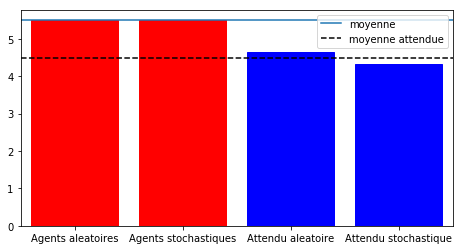

In [10]:
strat = ['Agents aleatoires','Agents stochastiques','Attendu aleatoire','Attendu stochastique']
score_attendu = [5.5, 5.5,4.65, 4.32]
moyenne = (score_attendu[0]+score_attendu[1])/2
attendu_moyenne = (score_attendu[2] + score_attendu[3])/2
colors = ['r','r','b','b']
fig = plt.figure(figsize=(6,3))
ax = fig.add_axes([0,0,1,1])
ax.set_xlim(-0.5,3.5)
ax.plot([-0.5,3.5],[moyenne,moyenne], label='moyenne')
ax.plot([-0.5,3.5],[attendu_moyenne,attendu_moyenne],"k--", label='moyenne attendue')
ax.bar(strat,score_attendu)
ax.legend()
for x,c in zip(ax.get_children(), colors):
    x.set_color(c)
plt.show()

## Tétue et Stochastique

In [14]:
dfs = df_interaction(2, ['random_obstinate', 'stochastic'])

In [15]:
display_data(dfs[0])

random_obstinate
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           51.4               257          1         88         24
1           48.6               243          2         85         25
2           79.2               396          3         90         72
3           45.2               226          4         79         22
4           66.6               333          5         88         37
5           50.4               252          6         75         36
6           48.4               242          7         69         37
7           65.2               326          8         87         37
8           61.6               308          9         88         36
9           60.6               303         10         85         36
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean       57.720000        288.600000    5.50000  83.400000  36.200000
std        10.74893

In [16]:
display_data(dfs[1])

stochastic
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0            3.4                17          1          4          3
1            4.6                23          2          6          4
2            4.0                20          3          5          3
3            4.2                21          4          5          3
4            4.4                22          5          5          3
5            4.4                22          6          5          3
6            4.2                21          7          5          3
7            5.4                27          8          7          4
8            4.0                20          9          5          3
9            3.8                19         10          5          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000          10.00000   10.00000  10.000000  10.000000
mean        4.240000          21.20000    5.50000   5.200000   3.200000
std         0.531664     

In [17]:
display_data(dfs[2])

Agents
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           27.4               274          1         88          3
1           26.6               266          2         85          4
2           41.6               416          3         90          3
3           24.7               247          4         79          3
4           35.5               355          5         88          3
5           27.4               274          6         75          3
6           26.3               263          7         69          3
7           35.3               353          8         87          4
8           32.8               328          9         88          3
9           32.2               322         10         85          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean       30.980000        309.800000    5.50000  83.400000   3.200000
std         5.404073         

On observe des résultats très similaires à ceux pour les groupes tétue-aleatoire, ce qui semble raisonnable vu la similitude entre les stratégies stochastique et aleatoire.

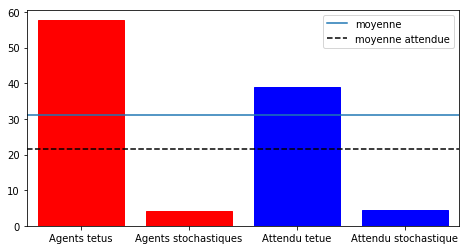

In [11]:
strat = ['Agents tetus','Agents stochastiques','Attendu tetue','Attendu stochastique']
score_attendu = [57.72, 4.24,38.85, 4.32]
moyenne = (score_attendu[0]+score_attendu[1])/2
attendu_moyenne = (score_attendu[2] + score_attendu[3])/2
colors = ['r','r','b','b']
fig = plt.figure(figsize=(6,3))
ax = fig.add_axes([0,0,1,1])
ax.set_xlim(-0.5,3.5)
ax.plot([-0.5,3.5],[moyenne,moyenne], label='moyenne')
ax.plot([-0.5,3.5],[attendu_moyenne,attendu_moyenne],"k--", label='moyenne attendue')
ax.bar(strat,score_attendu)
ax.legend()
for x,c in zip(ax.get_children(), colors):
    x.set_color(c)
plt.show()

## Comparant 5 stratégies (groupes de 2)

In [19]:
dfs = df_interaction(5, ['random_obstinate','uniformly_random','min_distance','min_occupation_forgetful','stochastic'])

In [20]:
display_data(dfs[0])

random_obstinate
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           38.0                76          1         43         33
1           40.0                80          2         43         37
2           58.0               116          3         86         30
3           77.5               155          4         79         76
4           60.0               120          5         84         36
5           46.0                92          6         48         44
6           42.5                85          7         45         40
7           84.5               169          8         89         80
8           59.5               119          9         86         33
9           48.5                97         10         59         38
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000   10.00000
mean       55.450000        110.900000    5.50000  66.200000   44.70000
std        15.71349

In [21]:
display_data(dfs[1])

uniformly_random
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0            4.0                 8          1          5          3
1            5.0                10          2          6          4
2            4.0                 8          3          5          3
3            4.5                 9          4          5          4
4            3.5                 7          5          4          3
5            4.5                 9          6          5          4
6            4.0                 8          7          4          4
7            3.5                 7          8          4          3
8            3.5                 7          9          4          3
9            4.0                 8         10          4          4
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean        4.050000          8.100000    5.50000   4.600000   3.500000
std         0.49721

In [22]:
display_data(dfs[2])

min_distance
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           89.5               179          1         90         89
1           96.5               193          2         98         95
2           34.5                69          3         39         30
3           90.5               181          4         93         88
4           70.0               140          5         89         51
5           45.5                91          6         46         45
6           83.0               166          7         87         79
7           91.0               182          8         95         87
8           78.5               157          9         96         61
9           90.0               180         10         97         83
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean       76.900000        153.800000    5.50000  83.000000  70.800000
std        21.001058   

In [23]:
display_data(dfs[3])

min_occupation_forgetful
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0            3.5                 7          1          4          3
1            4.0                 8          2          5          3
2            3.5                 7          3          4          3
3            4.5                 9          4          5          4
4            3.5                 7          5          4          3
5            4.5                 9          6          6          3
6            4.0                 8          7          4          4
7            3.0                 6          8          3          3
8            4.5                 9          9          6          3
9            3.0                 6         10          3          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean        3.800000          7.600000    5.50000   4.400000   3.200000
std        

In [24]:
display_data(dfs[4])

stochastic
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0            4.0                 8          1          5          3
1            4.0                 8          2          4          4
2            5.0                10          3          6          4
3            3.0                 6          4          3          3
4            4.0                 8          5          4          4
5            3.0                 6          6          3          3
6            3.5                 7          7          4          3
7            4.5                 9          8          5          4
8            4.0                 8          9          5          3
9            4.0                 8         10          5          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000  10.000000
mean        3.900000          7.800000    5.50000   4.400000   3.400000
std         0.614636     

In [25]:
display_data(dfs[5])

Agents
   Average Score  Cumulative Score  Iteration  Max Score  Min Score
0           27.8               278          1         90          3
1           29.9               299          2         98          3
2           21.0               210          3         86          3
3           36.0               360          4         93          3
4           28.2               282          5         89          3
5           20.7               207          6         48          3
6           27.4               274          7         87          3
7           37.3               373          8         95          3
8           30.0               300          9         96          3
9           29.9               299         10         97          3
       Average Score  Cumulative Score  Iteration  Max Score  Min Score
count      10.000000         10.000000   10.00000  10.000000       10.0
mean       28.820000        288.200000    5.50000  87.900000        3.0
std         5.351178         

Pour ce test, les grands bénéficiés sont les stratégies tetue et de distance minimale, qui ont un score très haut (comparé avec son score attendu). Le reste des stratégies ont des résultats plus bas que ceux qu'on attendait. Dans le graphique en dessous on peut voir les différences (en rouge les scores des groupes d'agents en moyenne et en bleu les scores attendus en voyant la première partie de ce projet). 

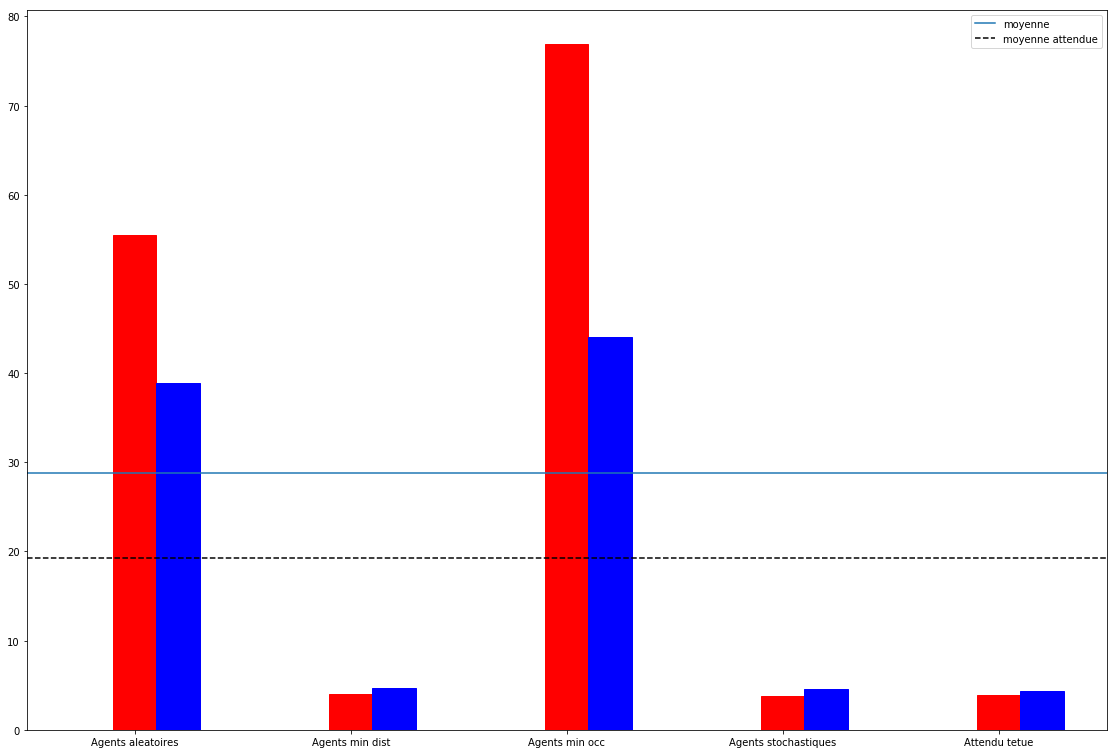

In [34]:
strat_agents = ['Agents tetus','Agents aleatoires', 'Agents min dist', 'Agents min occ', 'Agents stochastiques']
strat_att = ['Attendu tetue','Attendu aleatoire', 'Attendu min dist', 'Attendu min occ', 'Attendu stochastique']
score_agents = [55.45,4.05,76.9,3.8,3.9]
score_att = [38.85, 4.65,44.1,4.55,4.32]
moyenne = np.average(score_agents)
attendu_moyenne = np.average(score_att)
colors = ['r' for _ in strat_agents] + ['b' for _ in strat_att]
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax.set_xlim(-0.5,4.5)
ax.plot([-0.5,4.5],[moyenne,moyenne], label='moyenne')
ax.plot([-0.5,4.5],[attendu_moyenne,attendu_moyenne],"k--", label='moyenne attendue')
w = 0.2
b1 = [i for i in range(len(strat_agents))]
b2 = [i+w for i in b1]
ax.bar(b1+b2,(score_agents+score_att),width=w)
ax.set_xticklabels(strat_agents+strat_att)
ax.legend()
for x,c in zip(ax.get_children(), colors):
    x.set_color(c)
plt.show()

# Pour aller plus loin

Cette partie du rapport indique les vois d'exploration qui restent ouvertes pour obtenir plus d'information sur l'effectivité des stratégies indiqués ou pour obtenir plus d'information sur le problème à resoudre.

- **Suivie des évolutions d'occupation des restaurants**

On aurait pu suivre l'évolution de l'occupation des restaurants pendant le temps de simulation selon la stratégie, ce qui montrerait plus en détail les différences entre les stratégies des agents. On laisse en dessous un petit morceau de code avec les graphiques de cette évolution pour les méthodes mentionnés.

In [36]:
N_RESTAURANTS = 6

def plot_occupation(stats):
    restaurants = [stats['restaurant ' + str(i+1)] for i in range(N_RESTAURANTS)]
    T = len(restaurants[0])
    plt.figure(figsize=(20,10))
    for i,r in zip(range(len(restaurants)),restaurants):
        plt.plot(range(T),r,label='restaurant'+str(i+1))
    plt.legend()
    plt.show()

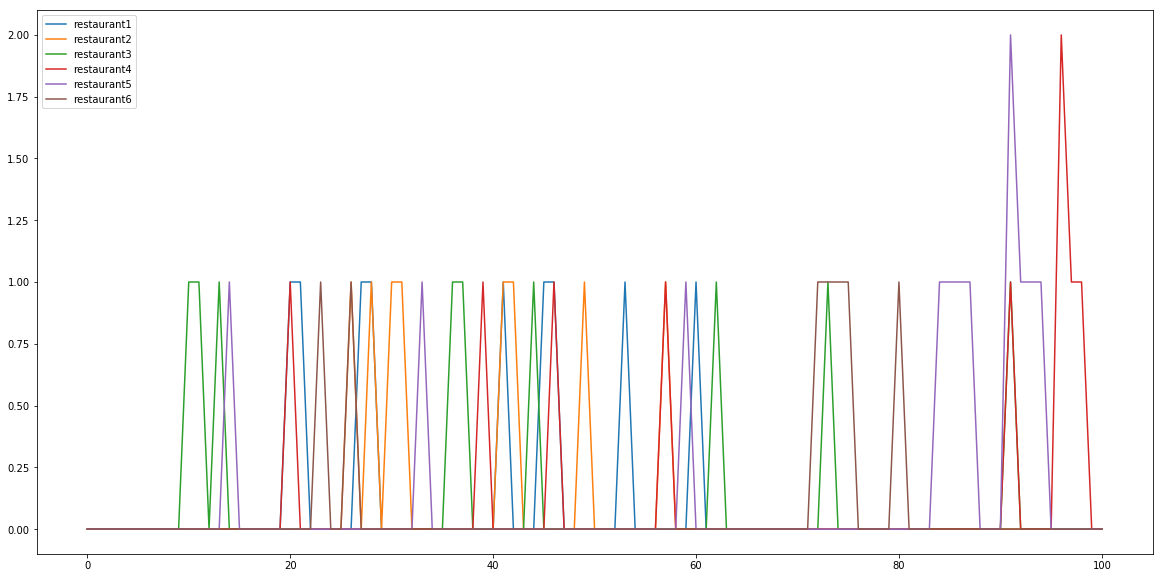

In [37]:
stats = simulate(1, ['uniformly_random'])
plot_occupation(stats)

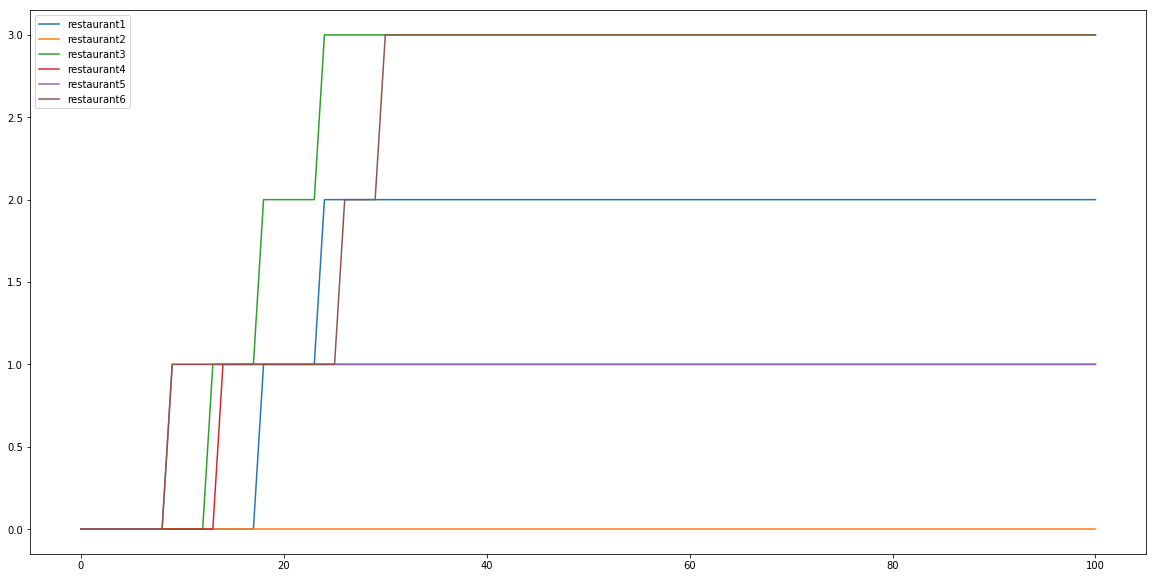

In [38]:
stats = simulate(1, ['random_obstinate'])
plot_occupation(stats)

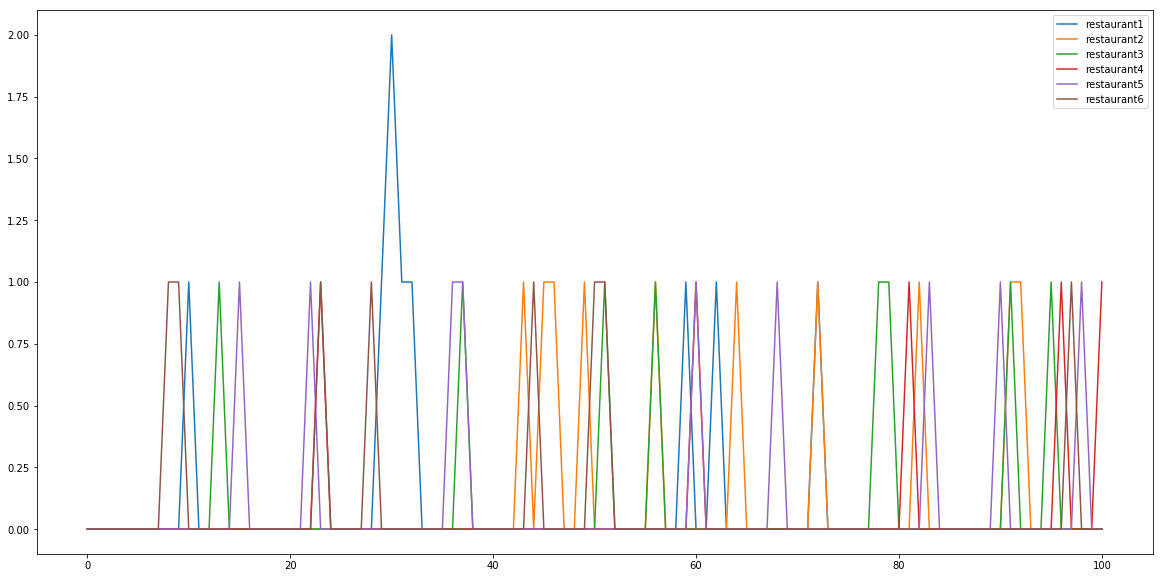

In [39]:
stats = simulate(1,['stochastic'])
plot_occupation(stats)

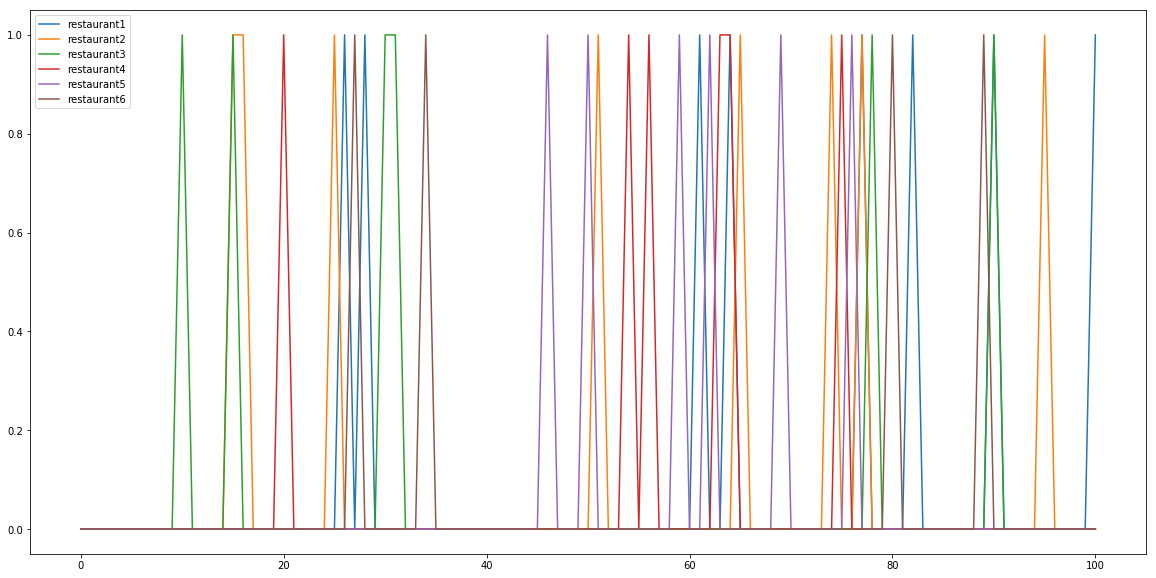

In [43]:
stats = simulate(1,['min_occupation_forgetful'])
plot_occupation(stats)

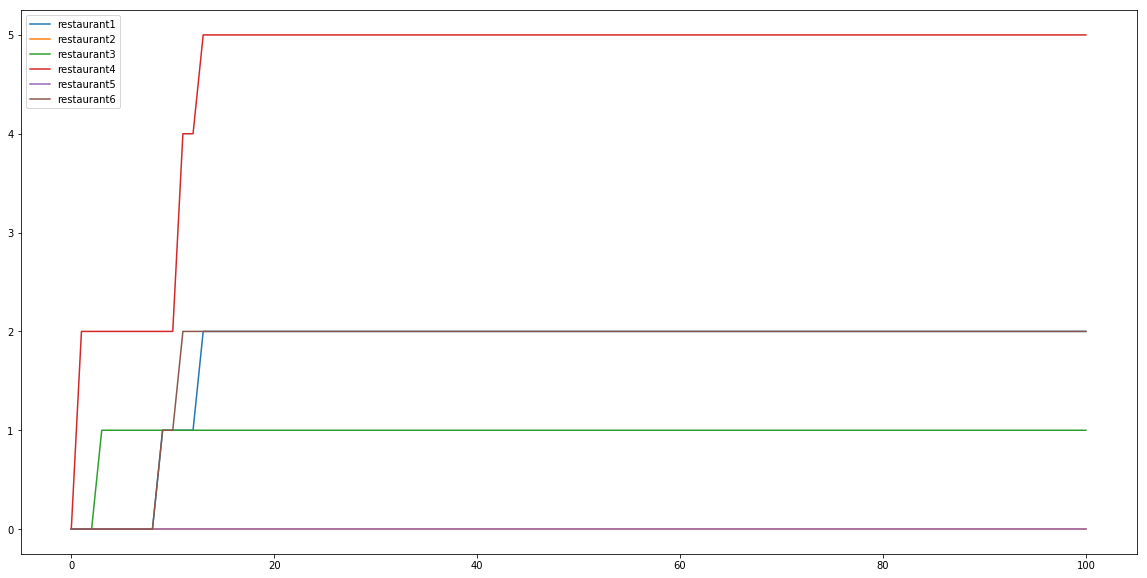

In [40]:
stats = simulate(1,['min_distance'])
plot_occupation(stats)

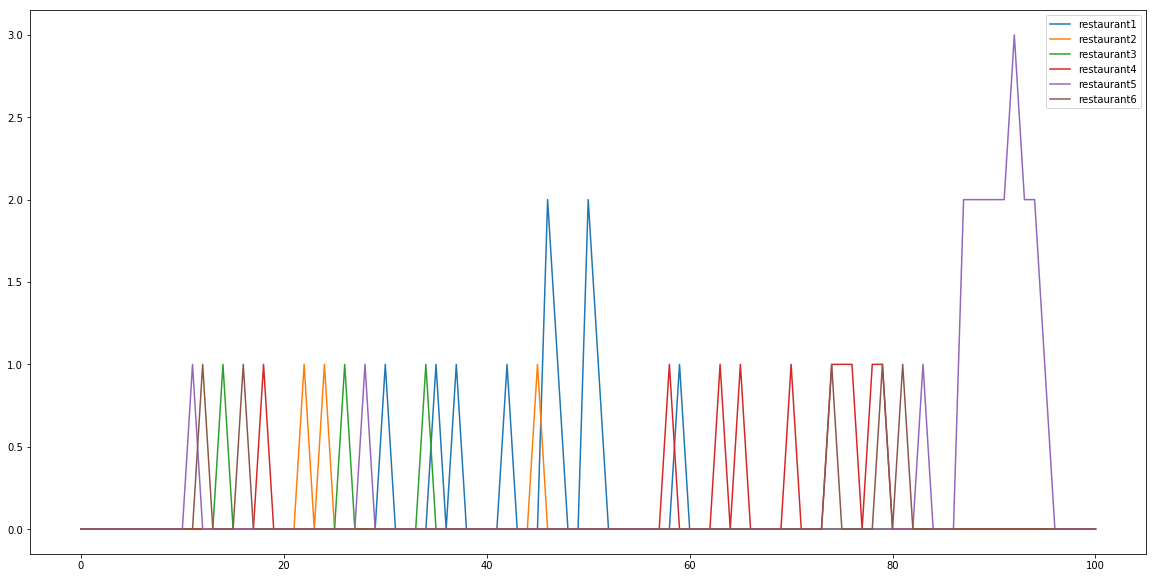

In [41]:
stats = simulate(1, ['min_occupation_avg'])
plot_occupation(stats)

- **Étude des occupations moyennes**

On aurait pu étudier les taux d'occupation moyennes des restaurants après simulation pour chaque stratégie.

- **Taux d'utilisation, d'attente et de déplacement des agents**

Pour obtenir plus d'information sur l'utilisation des restaurants et les attentes, on aurait pu obtenir des differentes taux. On explicite les calculations de quelques taux sur les agents avec information de valeur pour ce problème.

$$\tau_{utilisation,k} = \frac{t_{restaurant,k}}{T} \quad \tau_{deplacement,k} = \frac{t_{deplacement,k}}{T}  \quad \tau_{attente,k} = \frac{t_{attente,k}}{T}$$

où $T$ est le temps total (steps) de simulation, $t_{restaurant,k}$ est le temps que l'agent $k$ a passé en train d'être servi dans un restaurant, $t_{deplacement,k}$ est le temps que l'agent $k$ a passé en train de se déplacer et $t_{attente,k}$ est le temps que l'agent $k$ a passé en attente dans un restaurant. On a, de plus, la relation

$$\tau_{utilisation,k} + \tau_{deplacement,k} + \tau_{attente,k} = 1$$

- **Autres stratégies**

On aurait pu tester autres stratégies. Par exemple, on aurait pu tester des stratégies qui penalisent les restaurants qui font attendre les agents soit de manière déterministe (attente minimale) soit de manière stochastique (la probabilité de choisir le $k$-ème restaurant décroit à chaque instant d'attente). 

On aurait aussi pu utiliser une stratégie du type retour à la moyenne ou des stratégies essayant d'équaliser les résultats de chaque agent. C'est-à-dire, de minimiser la différence entre le score minimum et maximum à chaque simulation.

- **Flexibilisation du scénario**

Le scénario a des particularités qui ne sont pas tenues en compte pendant notre test. Par exemple, comme on a dit auparavant, les agents attendent au restaurant jusqu'au moment quand ils sont servis. Si on permet les agents de changer son choix on a potentiellement une opportunité pour certaines stratégies d'ameliorer ses résultats.